In [17]:
!pip install transformers

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [18]:
from transformers import BertTokenizer, TFBertModel

In [49]:
import warnings
warnings.filterwarnings('ignore')

#### Создание TPU - мощных аппаратных ускорителей, специализирующихся на задачах глубокого машинного обучения, включая обработку естественных языков

In [20]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # CPU, single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


#### Подготовка обучающих данных

In [21]:
train_data = pd.read_csv("kaggle/input/contradictory-my-dear-watson/train.csv")

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


#### Просмотр распределения языков в обучающем наборе

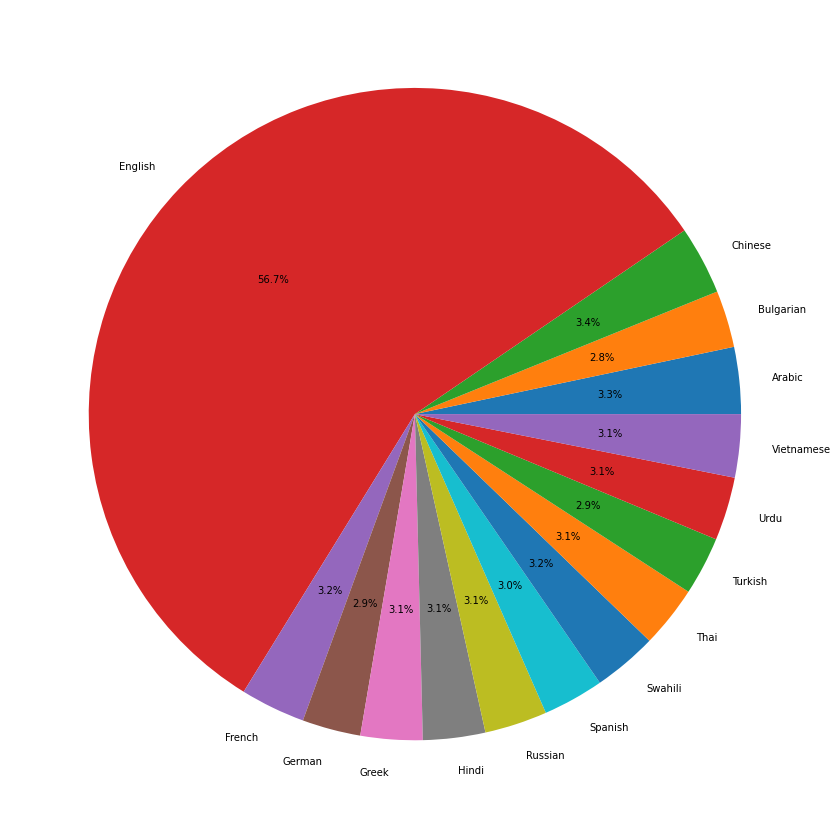

In [24]:
labels, frequencies = np.unique(train_data.language.values, return_counts=True)
plt.figure(figsize=(15, 15))
plt.pie(frequencies, labels=labels, autopct='%1.1f%%')
plt.show()

#### Токенизатор для перевода последовательности слов в массивы чисел

In [25]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

#### Подготовка входных данных для обучения модели

In [35]:
max_len = 50

def bert_encode(hypotheses, premises, tokenizer):
  num_examples = len(hypotheses)

  sentences = [hypothesis + ' [SEP] ' + premise
               for hypothesis, premise in zip(
                   np.array(hypotheses),
                   np.array(premises))]
  sentences = tokenizer(sentences, padding=True, truncation=True, max_length=max_len)

  return {
      'input_word_ids': tf.ragged.constant(sentences['input_ids']).to_tensor(),
      'input_mask': tf.ragged.constant(sentences['attention_mask']).to_tensor(),
      'input_type_ids': tf.ragged.constant(sentences['token_type_ids']).to_tensor()}

In [36]:
train_input_data = bert_encode(
    train_data.premise.values,
    train_data.hypothesis.values,
    tokenizer)

## Создание и обучение модели

In [37]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)

    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [38]:
with strategy.scope():
    model = build_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [39]:
model.fit(
    train_input_data,
    train_data.label.values,
    epochs = 2,
    verbose = 1,
    batch_size = 64,
    validation_split = 0.2)

Epoch 1/2
152/152 [==============================] - 5651s 37s/step - loss: 1.1241 - accuracy: 0.3543 - val_loss: 1.0079 - val_accuracy: 0.4860
Epoch 2/2
152/152 [==============================] - 5735s 38s/step - loss: 0.9749 - accuracy: 0.5283 - val_loss: 0.9508 - val_accuracy: 0.5359


#### Подготовка тестовых данных

In [40]:
test_data = pd.read_csv("kaggle/input/contradictory-my-dear-watson/test.csv")

In [44]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5195 entries, 0 to 5194
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5195 non-null   object
 1   premise     5195 non-null   object
 2   hypothesis  5195 non-null   object
 3   lang_abv    5195 non-null   object
 4   language    5195 non-null   object
dtypes: object(5)
memory usage: 203.1+ KB


In [42]:
test_input_data = bert_encode(test_data.premise.values, test_data.hypothesis.values, tokenizer)

## Работа модели на тестовых данных

In [45]:
predictions = [np.argmax(i) for i in model.predict(test_input_data)]

In [46]:
submission = test_data.id.copy().to_frame()
submission['prediction'] = predictions

In [47]:
submission.head()

,id,prediction
0,c6d58c3f69,0
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,2


#### Запись результатов в файл csv

In [48]:
submission.to_csv("submission.csv", index=False)